# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * ~~Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.~~
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky importujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [2]:
import requests
import re
import time
import pandas as pd
from bs4 import BeautifulSoup

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

# Website analysis

While browsing through the individual votings, I noticed that the URL of each of them contains a specific index (Voting ID) which identifies the voting. Going from one voting to the next is done by simply incrementing this index, therefore I noted down the index of the first and the last voting in order to make browsing the domain more efficient.

In [3]:
# important information extracted from website analysis

voting_start = 69445 # index hidden in the URL of the first voting
voting_end = 73901 # index in the URL of the last voting
char_set = 'windows-1250' # document character set for the website

# constants

VOTINGS_FILE = 'data/votings.csv' # file to store general data about each voting that took place
INDIVIDUALS_FILE = 'data/individuals.csv' # file to store data about every single cast vote 
PARTIES_FILE = 'data/parties.csv' # file to store data about every paty's collective result for each voting
COLLECT_DATA = False # time to process = 4711.013979911804

# Web scraping

The following section performs web scraping on the given domain. It will only run if the constant COLLECT_DATA is set to True. I have decided to split the data into three different data frames:
* **votings (data/votings.csv)** - this df contains information about each individual voting that took place in the chamber of deputies (Voting ID, Meeting number, Voting number, Subject/Name, Number of voters, Number of Yes votes, Number of No votes, Number of Unregistered votes, Number of Refrained votes, Number of Excused votes, Whether the agenda was accepted, Whether the voting was pronounced as Valid)
<br/><br/>
* **individuals (data/individuals.csv)** - this df contains information about every single vote cast by each deputy (Deputy name, Deputy's party, Voting ID, Vote cast)
<br/><br/>
* **parties (data/parties.csv)** - this df contains information about each party's collective result in every single voting (Party's name, Voting ID, Number of Yes votes, Number of No votes, Number of Unregistered votes, Number of Refrained votes, Number of Excused votes, Which of the votes was most common - Yes/No/Other)
<br/><br/>
I believe this specific data organization will be useful when visualizing data, because not only will I have information about the results of each voting, but I will also be able to acces data about the result structure (how each deputy voted, how each party viewed the voting as a collective, etc.). The information about parties' votes could be calculated from the individuals data frame, but I think it would be less efficient so I decided to store the data in a separate file.

In [9]:
# creates csv files to store data in (if files already exist, they get wiped)
def setup_files():
    f = open(VOTINGS_FILE, 'w', encoding='utf-8')
    f.write('Voting ID;Meeting number;Voting number;Subject;Number of voters;Yes;No;Unregistered;Refrained;Excused;Passed;Valid\n')
    f.close()
    
    f2 = open(INDIVIDUALS_FILE, 'w', encoding='utf-8')
    f2.write('Name;Party;Voting ID;Vote\n')
    f2.close()
    
    f3 = open(PARTIES_FILE, 'w', encoding='utf-8')
    f3.write('Party;Voting ID;Yes;No;Unregistered;Refrained;Excused;Max\n')
    f3.close()


# function takes header of the website and returns a list including its basic information
# [meeting number, voting number, date, time, subject]
def split_header(header):
    match = re.search(r'[0-9][0-9]:[0-9][0-9]', header)
    if not match:
        raise Exception('Unable to split header')
    split = match.end()
    arr = [header[:split], header[split:]]
    res = [x.strip() for x in arr[0].split(',')]
    res.append(arr[1].strip() if len(arr[1]) > 0 else "''")
    res[0] = res[0].split('.')[0]
    res[1] = res[1].split('.')[0]
    return res
    

# extracts general information about a single voting and appends it to the votings.csv file
def process_voting(voting_index, soup):
    main = soup.find('div', { 'id' : 'main-content' })

    # process header
    voting_header = soup.find('h1', { 'class' : 'page-title-x' }).get_text()
    header = split_header(voting_header)
    f = open(VOTINGS_FILE, 'a', encoding='utf-8')
    f.write(f'{voting_index};{header[0]};{header[1]};{header[4]}; ')

    # process vote summary table
    cell = soup.find_all('i', text=re.compile('Celkem'))[0].parent.parent
    curr = cell.next_sibling
    for i in range(6):
        f.write(f'{curr.get_text()};')
        curr = curr.next_sibling

    # vote passed?
    summary = soup.find('div', {'class' : 'summary'})
    result = summary.find('span')
    f.write('1;') if result.get_text() == 'NÁVRH BYL PŘIJAT' else f.write('0;')

    # valid election?
    status = soup.find_all('p', {'class': 'status invalid'})
    f.write('{valid}'.format(valid='0' if len(status) > 0 and status[0] == "Hlasování bylo prohlášeno za zmatečné." else '1\n'))
    f.close()
        

# extracts the data about a party's collective result in a given voting and appends this information to the parties.csv file
def process_party(voting_index, soup, party_info, text, name):
    f = open(PARTIES_FILE, 'a', encoding='utf-8')
    nums = party_info.find('span', {'class' : 'results'}).find_all('strong')
    
    i = 0
    if 'Ano:' in text:
        yes = nums[i].get_text()
        i += 1
    else:
        yes = 0
            
    if 'Ne:' in text:
        no = nums[i].get_text()
        i += 1
    else:
        no = 0
        
    if 'Nepřihlášen:' in text:
        unregistered = nums[i].get_text()
        i += 1
    else:
        unregistered = 0
        
    if 'Zdržel se:' in text:
        refrained = nums[i].get_text()
        i += 1
    else:
        refrained = 0
        
    if 'Omluven:' in text:
        excused = nums[i].get_text()
        i += 1
    else:
        excused = 0
    
    sums = {'Y': int(yes), 'N': int(no), 'O': int(unregistered) + int(refrained) + int(excused)}
    
    #print(f'{name}: {yes},{no},{unregistered},{refrained},{excused},{max(sums, key=lambda key: sums[key])}')
    f.write(f'{name};{voting_index};{yes};{no};{unregistered};{refrained};{excused};{max(sums, key=lambda key: sums[key])}\n')
    f.close()
        

# extracts some data about each party's vote in a given voting and sends this data over to the process_parties()
# function where they are further processed and stored
# for each party, the function analyses individual deputies' votes and stores them in the individuals.csv file
# vote: A (yes), N (no), 0 (Unregistered), Z (refrained), M (excused)
def process_individuals(voting_index, soup):
    party_tables = soup.find('div', {'id' : 'main-content'}).find_all('h2', {'class' : 'section-title center'})[1:]
    res_tables = soup.find_all('ul', {'class' : 'results'})
    
    for i in range(len(party_tables) - 1):
        party_info = party_tables[i].find('span')
        text = party_info.get_text()
        if 'Tabulkovy vypis' in text:
            continue

        tmp = text.split(" ", 1)
        party_name = text.split(' ', 1)[0]
        process_party(voting_index, soup, party_info, text, party_name)
        
        party_voters = res_tables[i].find_all('li')
        f2 = open(INDIVIDUALS_FILE, 'a', encoding='utf-8')
        for voter in party_voters:
            name = voter.find('a').get_text()
            vote = voter.find('span').contents[0]
            #print(f'{name}, {party_name}, {vote}')
            f2.write(f'{name};{party_name};{voting_index};{vote}\n')
        f2.close()


# sends GET request to URL given by a specific voting ID, creates a soup object and sends data for further processing
# if voting results have not yet been published and finalized, an error message informs the user about its Voting ID
def process_page(voting_index):
    try:
        url = f'https://www.psp.cz/sqw/hlasy.sqw?g={voting_index}&l=cz'
        res = requests.get(url)
        html_page = res.content
        soup = BeautifulSoup(html_page, 'html.parser', from_encoding=char_set)
        
        process_voting(voting_index, soup)
        process_individuals(voting_index, soup)
    except Exception as e:
        print(f'Could not parse page: {voting_index} ... {e}')


# main function leading the whole web scraping process
# ensures a 1 second wait time between each request so as not to overload the targeted domain
def process_data():
    start = time.time()
    setup_files()
    
    for i in range(voting_start, voting_end + 1):
        if i % 100 == 0:
            print(f'Processing page: {i}')
        process_page(i)
        time.sleep(0.3)
        
    end = time.time()
    print(end - start)


if COLLECT_DATA:
    print('Starting data collection...')
    process_data()

Starting data collection...
Processing page: 69500
Processing page: 69600
Processing page: 69700
Processing page: 69800
Processing page: 69900
Processing page: 70000
Processing page: 70100
Processing page: 70200
Processing page: 70300
Processing page: 70400
Processing page: 70500
Processing page: 70600
Processing page: 70700
Processing page: 70800
Processing page: 70900
Processing page: 71000
Processing page: 71100
Processing page: 71200
Processing page: 71300
Processing page: 71400
Processing page: 71500
Processing page: 71600
Processing page: 71700
Could not parse page: 71782 ... HTTPSConnectionPool(host='www.psp.cz', port=443): Max retries exceeded with url: /sqw/hlasy.sqw?g=71782&l=cz (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002086A5CABC8>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because con

In [21]:
# load data
df_v = pd.read_csv('data/votings.csv', delimiter=';')
df_i = pd.read_csv('data/individuals.csv', delimiter=';')
df_p = pd.read_csv('data/parties.csv', delimiter=';')

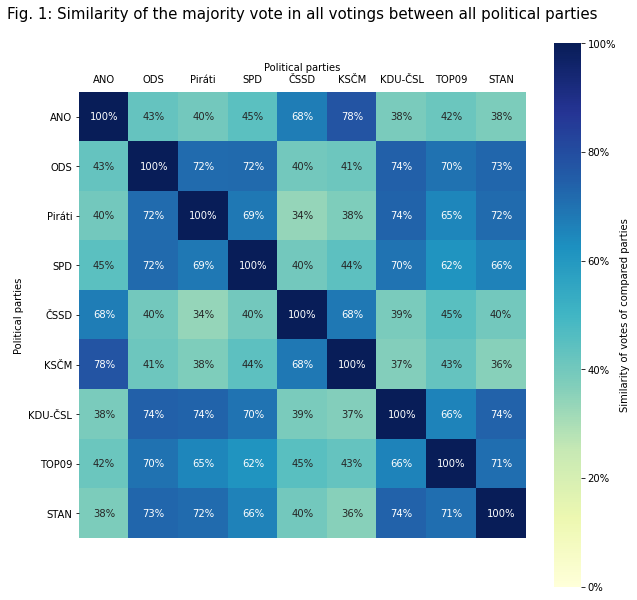

In [7]:
print('Processing data...')
df1 = df_p[df_p.Party != "Nezařaz"]
parties = (df1[df1['Voting ID'] == voting_start])['Party']
party_cnt = len(parties)

# create party vectors
party_matrix = []
for p in range(party_cnt):
    vec = df1[df1.Party == parties[p]]
    vec = vec['Max'].tolist()
    party_matrix.append([])
    for v in range(len(vec)):
        party_matrix[p].append(vec[v])         

voting_cnt = len(party_matrix[0])

# create matrix showing the similarity of parties' votes
similarity_matrix = np.zeros(shape=(len(parties), len(parties)))
for first in range(party_cnt):
    for second in range(party_cnt):
        matched = 0
        for voting in range(voting_cnt):
            if party_matrix[first][voting] == party_matrix[second][voting]:
                matched += 1
        similarity_matrix[first][second] = matched / voting_cnt
        #print(f'{first} and {second} matched {matched}x')
        
# visualize results using a heatmap
fig, ax = plt.subplots(figsize=(10, 10))

fmt = lambda x,pos: '{:.0%}'.format(x)
sns.heatmap(similarity_matrix, vmin=0, vmax=1, annot=True, square=True, cmap='YlGnBu', fmt='.0%', cbar_kws={'format': FuncFormatter(fmt),
                                                                                                           'label' : 'Similarity of votes of compared parties'})

ax.set_xticklabels(parties.tolist())
ax.set_yticklabels(parties.tolist(), rotation=0)
ax.set_title('Fig. 1: Similarity of the majority vote in all votings between all political parties', fontsize=15, y=1.15)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xlabel('Political parties')
plt.ylabel('Political parties')
ax.xaxis.set_label_position('top')

In [8]:
warnings.filterwarnings('ignore')
print('Processing data...')

df1 = df_p[df_p.Party != "Nezařaz"]
parties = (df1[df1['Voting ID'] == voting_start])['Party']
party_cnt = len(parties)

attendence_arr = []
for p in range(party_cnt):
    curr = df1[df1.Party == parties[p]]
    
    for df_index, row in curr.iterrows():
        attended = row.Yes + row.No + row.Refrained
        total = attended + row.Unregistered + row.Excused
        curr.loc[df_index, 'Attendence'] = attended / total
    attendence_arr.append(curr)

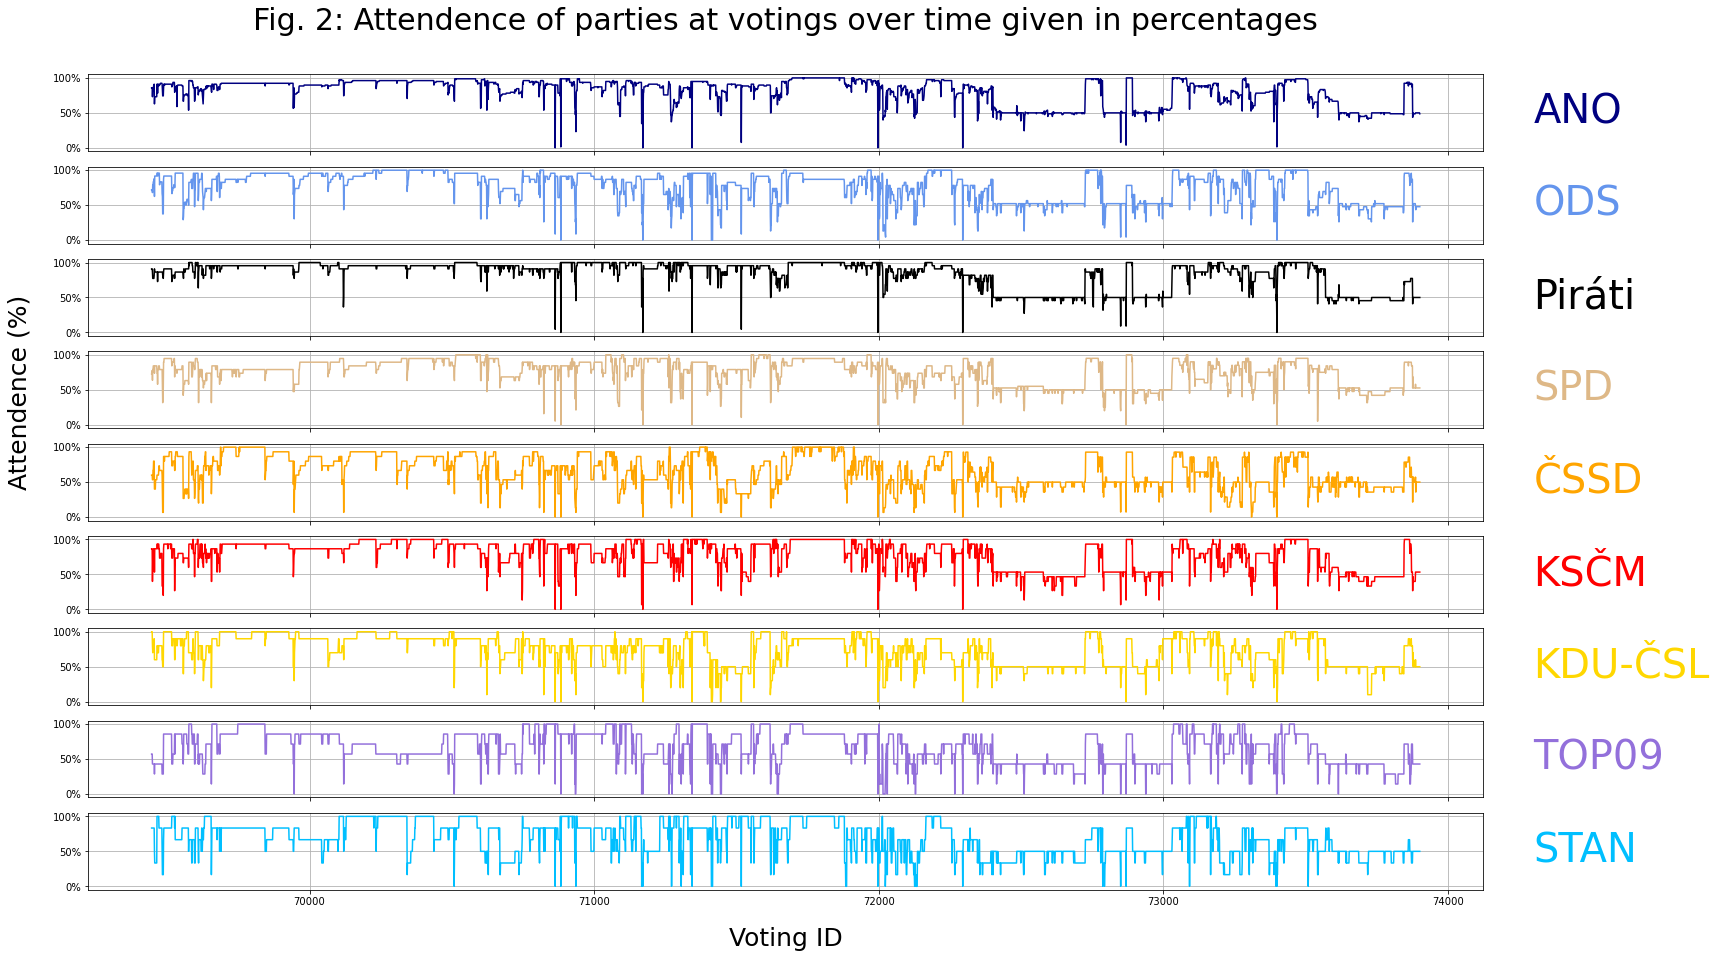

In [10]:
fig, axes = plt.subplots(9,1, figsize=(25,15), sharex=True)
colors = ['navy', 'cornflowerblue', 'black', 'burlywood', 'orange', 'red', 'gold', 'mediumpurple', 'deepskyblue']
plt.xlabel('Voting ID', fontsize=25, labelpad=20)
fig.text(0.08, 0.5, 'Attendence (%)', fontsize=25, rotation=90)

axes[0].set_title('Fig. 2: Attendence of parties at votings over time given in percentages', fontsize=30, y=1.5)

for i in range(len(attendence_arr)):
    curr = attendence_arr[i]
    axes[i].plot(curr['Voting ID'], curr['Attendence'], linewidth=1.5, color=colors[i])
    axes[i].get_yaxis().set_major_formatter(FuncFormatter(fmt))
    axes[i].grid(True)
    axes[i].text(74300, 0.35, curr['Party'].tolist()[0], fontsize=40, color=colors[i])
    
plt.show()

72500 - duben 2020 - korona zpusobila tak 50% ucast

In [24]:
print('Processing data...')

party_list = (df1[df1['Voting ID'] == voting_start])['Party'].tolist()

curr = df_i[df_i['Party'] == 'ANO']

all_absences = {}

for p in party_list:
    curr = df_i[df_i['Party'] == p]
    absences = {}
    
    for df_index, row in curr.iterrows():
        if row['Name'] in absences:
            if row['Vote'] == 'A' or row['Vote'] == 'N' or row['Vote'] == 'Z':
                absences[row['Name']]['Present'] += 1
            else:
                absences[row['Name']]['Absent'] += 1
        else:
            absences[row['Name']] = {}
            if row['Vote'] == 'A' or row['Vote'] == 'N' or row['Vote'] == 'Z':
                absences[row['Name']]['Present'] = 1
                absences[row['Name']]['Absent'] = 0
            else:
                absences[row['Name']]['Present'] = 0
                absences[row['Name']]['Absent'] = 1
    all_absences[p] = absences

print('Done')

Processing data...


In [120]:
from ipywidgets import interact

@interact
def show(Party=party_list):
    it = list(all_absences[Party].items())
    it.sort(key=lambda x: x[1]['Present']/(x[1]['Present']+ x[1]['Absent']), reverse=True)

    f, ax = plt.subplots(figsize=(10, len(it) * 0.2))
    
    x, y = zip(*it)
    y_list = []
    for i in y:
        y_list.append(i['Present'] / (i['Present'] + i['Absent']))
    ax = sns.barplot(y_list, list(x), label="Total", color=colors[party_list.index(Party)])
    ax.get_xaxis().set_major_formatter(FuncFormatter(fmt))
    plt.xlabel('Attendence (%)', fontsize=15, labelpad=20)
    plt.ylabel('Name of deputy', fontsize=15, labelpad=20)
    ax.set_title('Fig. 3: Attendence of members of each political party', fontsize=20, y=1.03)

interactive(children=(Dropdown(description='Party', options=('ANO', 'ODS', 'Piráti', 'SPD', 'ČSSD', 'KSČM', 'K…